## Import libraries and such

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load in an iris image and test Daugmans integro-differential operator

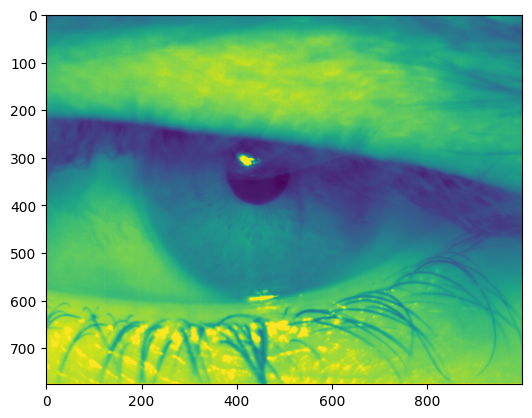

(776, 1000, 3)
0.0


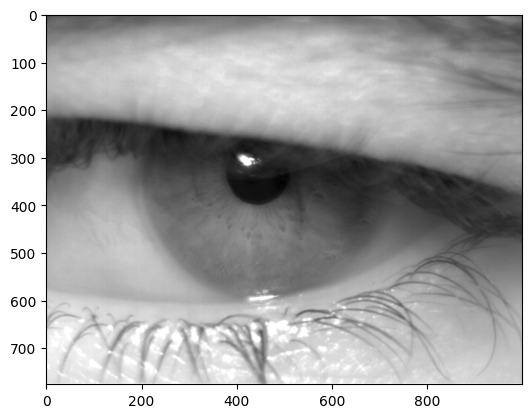

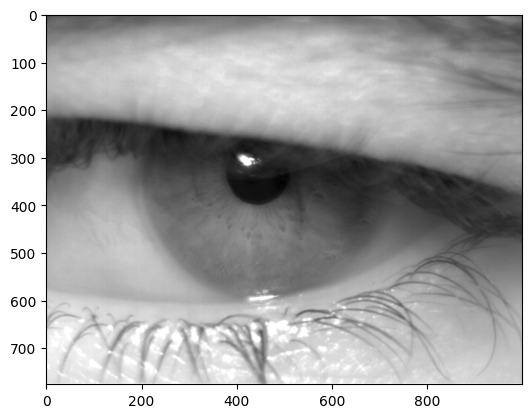

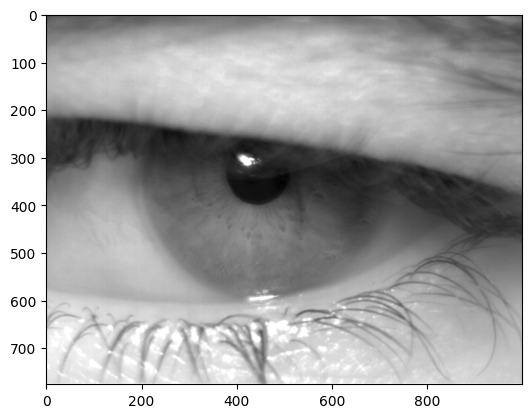

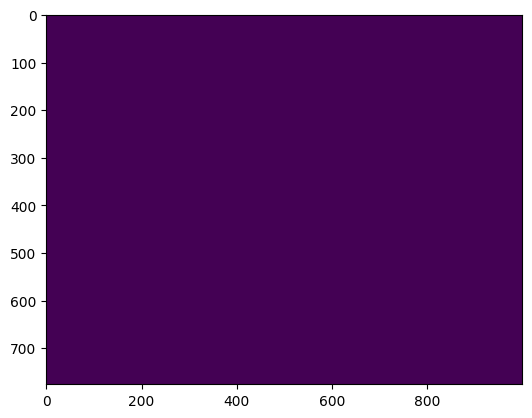

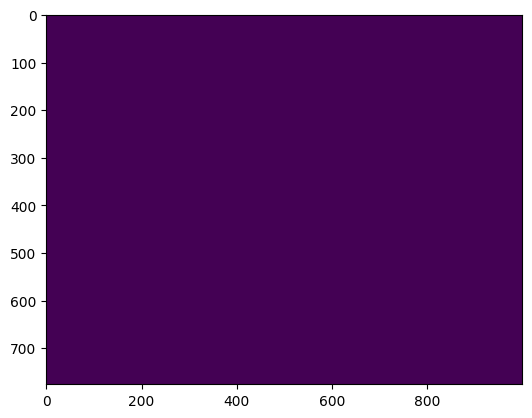

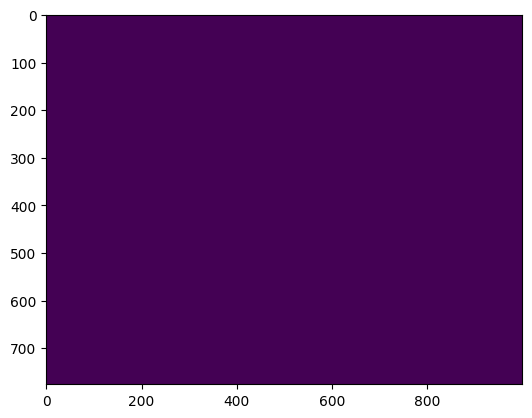

In [184]:
#img = cv2.imread("MMU-Iris-Database/1/left/aeval1.bmp").astype(np.double) / 255
img = cv2.imread("UTIRIS_infrared/001/001_L/Img_001_L_1_1.bmp").astype(np.double) / 255
img2 = cv2.cvtColor(cv2.imread("UTIRIS_infrared/001/001_L/Img_001_L_1_1.bmp"), cv2.COLOR_BGR2GRAY)
plt.imshow(img2)
plt.show()
print(img.shape)
print((np.abs(img[:, :, 2] - img[:, :, 1])).sum())
plt.imshow(img[:, :, 0], cmap="gray")
plt.show()
plt.imshow(img[:, :, 1], cmap="gray")
plt.show()
plt.imshow(img[:, :, 2], cmap="gray")
plt.show()
plt.imshow(img[:, :, 2] - img[:, :, 1])
plt.show()
plt.imshow(img[:, :, 0] - img[:, :, 1])
plt.show()
plt.imshow(img[:, :, 0] - img[:, :, 2])
plt.show()

## Rename the data to be easier accessible

### Daugmans integro-differential operator

153.5 58.5
Estimated pupil radius:  147
Estimated pupil center:  [335, 661]
Optimal location and radius:  
x=654.0
y=315.0
r=159.0
Estimated iris radius:  268
Optimal location and radius:  
x=653.0
y=305.0
r=268.0

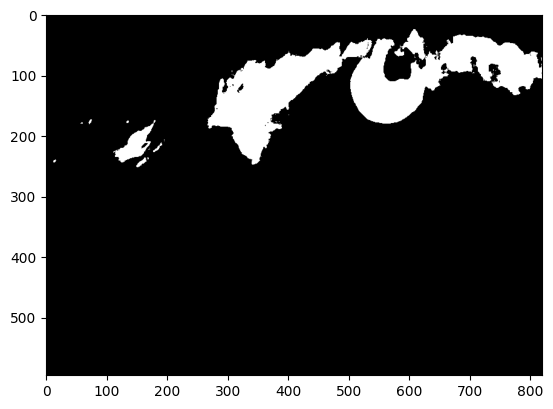

In [651]:
plt.imshow((img_use < 60).astype(int), cmap="gray")
plt.show()


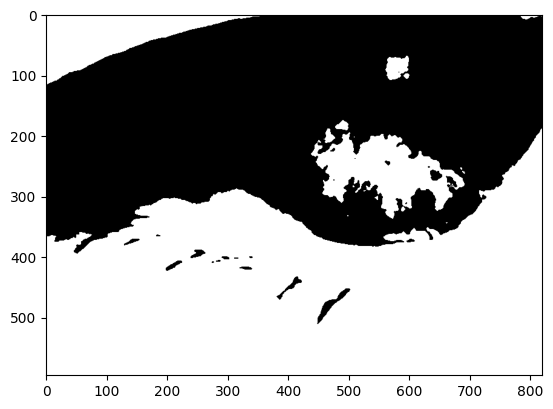

In [659]:
imgx  = cv2.medianBlur(img_use, 3)
plt.imshow((imgx > 120).astype(int), cmap="gray")
plt.show()

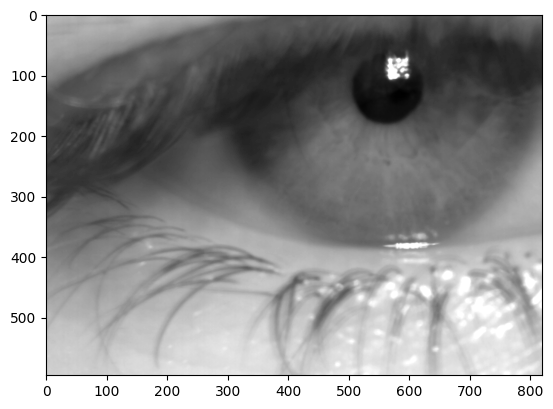

In [646]:
plt.imshow(img_use, cmap="gray")
plt.show()

In [3]:
from IrisSegmentation import FindPupilIris, LocateEyelids, LocateEyelids2, EyelidFitter
import skimage as skim
%load_ext autoreload
%autoreload 2

img_use = cv2.imread("UTIRIS_infrared/021/021_L/Img_021_L_5.bmp").astype(np.double)[: , :, 0] / 255
img_use = cv2.imread("UTIRIS_infrared/019/019_L/Img_019_L_1.bmp").astype(np.double)[: , :, 0] / 255
img_use = cv2.imread("UTIRIS_infrared/078/078_L/Img_078_L_5_1.bmp").astype(np.double)[: , :, 0] / 255
#img_use = cv2.imread("UTIRIS_infrared/060/060_R/Img_060_R_2_1.bmp").astype(np.double)[: , :, 0] / 255
img_use = cv2.imread("UTIRIS_infrared/075/075_R/Img_075_R_4_1.bmp",cv2.IMREAD_GRAYSCALE)#.astype(np.double) / 255


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Testing out canny and hough circle transform

In [5]:
import glob
infr_img = glob.glob("UTIRIS_infrared/*/*/*.bmp")


Full iris:  False


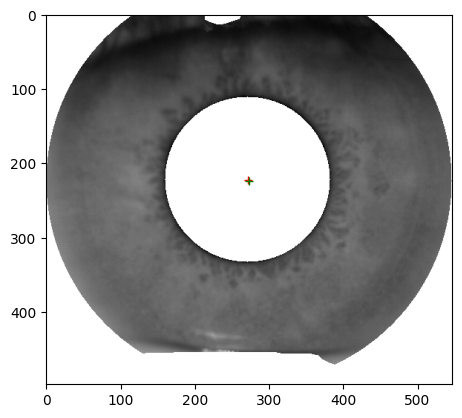

Full iris:  True


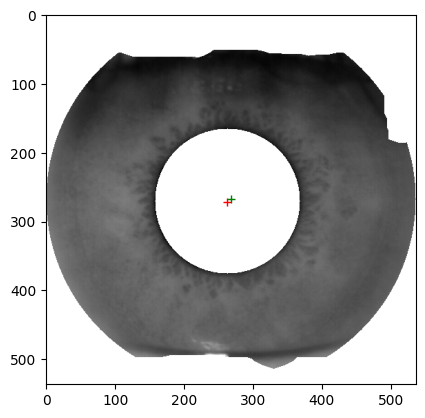

Full iris:  False


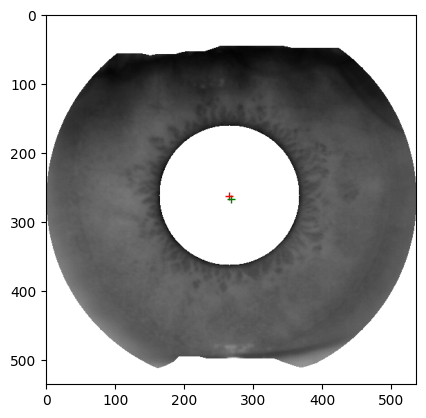

Full iris:  True


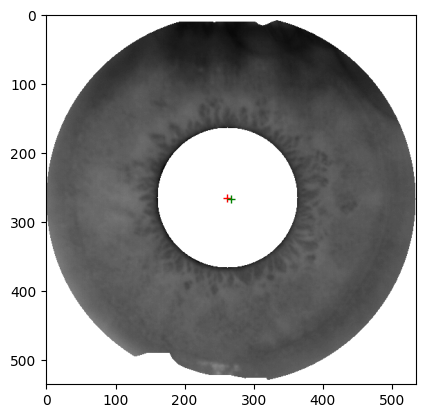

Full iris:  True


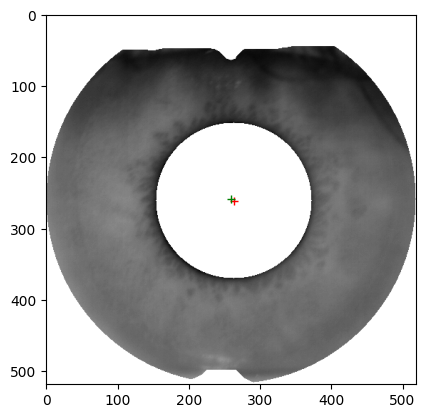

In [146]:
import glob
infr_img = glob.glob("UTIRIS_infrared/*/*/*.bmp")

from IrisSegmentation import FindEdge, FindEdgeLoss, EstimateRadius, FastIrisPupilScanner

for img in infr_img[70:75]:
    #img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)[75:-75, 75:-75]
    out = FastIrisPupilScanner(img)
    print("Full iris: ", out["full_iris"])
    #edges = cv2.Canny(img, 30, 40)
    plt.imshow(out["iris"], cmap="gray")
    plt.plot(out["pupil_xy"][1], out["pupil_xy"][0], "r+")
    plt.plot(out["iris_xy"][1], out["iris_xy"][0], "g+")
    plt.show()
    
    


